# Attention Model from scratch: tutorial

feat. Heterogeneuous Attention Model


Brief intro: implementation-wise, the biggest differences with most RL libraries are:
1. We use [TorchRL](https://github.com/pytorch/rl) for batched environments on GPU - tackling one of the biggest bottlenecks in RL (CPU-GPU overheads)
2. We pass states and more in the super-convenient [TensorDicts](https://github.com/pytorch-labs/tensordict)
3. Training is done in [PyTorch Lightning](https://github.com/Lightning-AI/lightning), which takes care of multiple devices, logging, checkpointing, etc.
4. We use [Hydra](https://hydra.cc/) for configuration management
5. Code is made to be as modular as possible and implemented with the latest DL advances as [FlashAttention](https://github.com/HazyResearch/flash-attention)


This should allow for easy, fast, and scalable experimentation in the future and we hope to become the to-go library for RL4CO research 🚀

In [48]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

from omegaconf import OmegaConf, DictConfig

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L
from tensordict import TensorDict

from rl4co.envs import PDPEnv
from rl4co.models.rl.reinforce import RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.data.dataset import TensorDictCollate, TensorDictDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment
We test on a simple TSP environment

In [33]:
def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy):
    """Helper function to rollout a policy"""
    actions = []
    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
    actions = torch.stack(actions, dim=1)
    td.set("action", actions)
    return td

In [34]:
env = PDPEnv(num_loc=20)

td = env.reset(batch_size=[5])
init_td = td.clone()
td = rollout(env, td, random_policy)
env.get_reward(td, td['action'])

tensor([-12.4679, -10.5297, -10.4129, -10.3520, -10.8689])

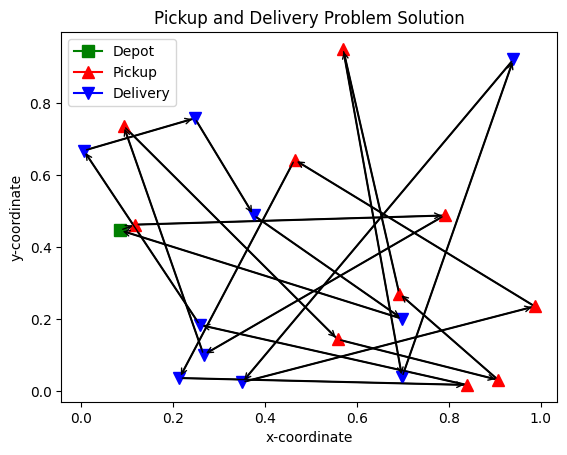

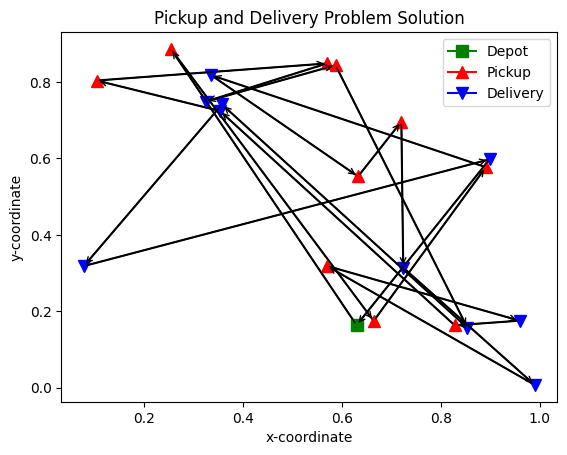

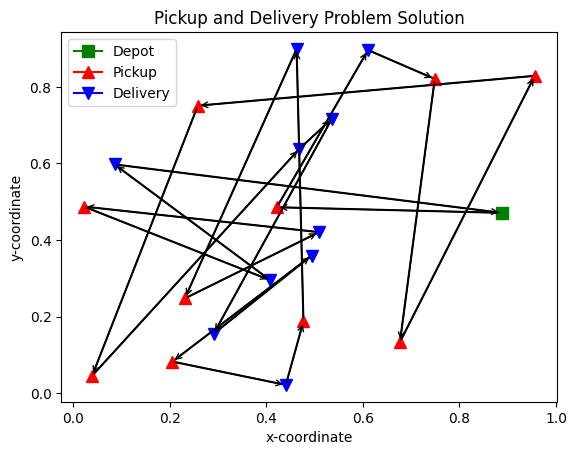

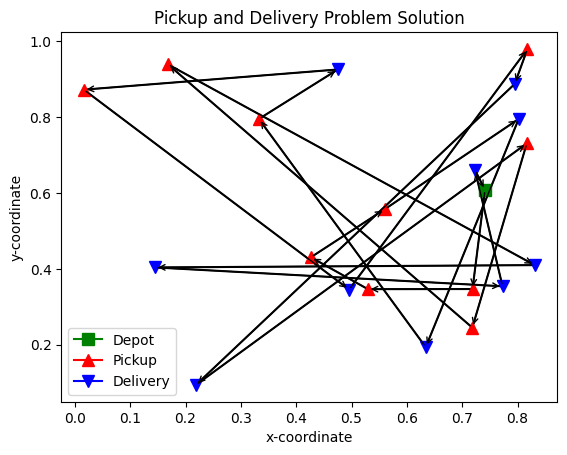

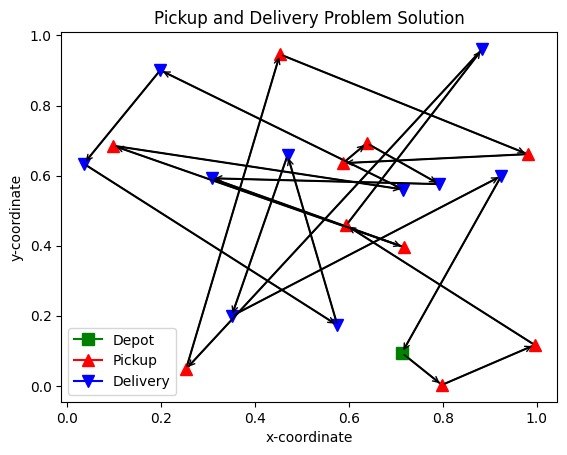

In [35]:
# Plot 
render_td = td.clone()
render_td.set('to_deliver', init_td['to_deliver'])

for i in range(5):
    env.render(render_td[i])

## Encoder

We use a `GraphHeterogeneousAttentionEncoder` that is shared with most models (we just import it from RL4CO)

In [36]:
from rl4co.models.zoo.ham.encoder import GraphHeterogeneousAttentionEncoder
# ?? GraphHeterogeneousAttentionEncoder

## Decoder 

We can also simply import it from AM

In [37]:
from rl4co.models.zoo.am.decoder import Decoder
# ?? Decoder

## Policy

The policy takes an initial state and gives back collected rewards and log likelihood. We can also return extras such as actions

In [38]:
from rl4co.models.zoo.am.policy import AttentionModelPolicy
# ?? AttentionModelPolicy

In [39]:
# Load environment with test data
env = PDPEnv()

# Encoder params
embedding_dim = 128
num_layers = 3
num_heads = 8

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=TensorDictCollate(),
)

# NOTE: declaring encoder / decoder will override the default ones in the policy
policy = AttentionModelPolicy(
    env,
    encoder=GraphHeterogeneousAttentionEncoder( # override the encoder with our own
        num_heads=num_heads,
        embed_dim=embedding_dim,
        num_layers=num_layers,
    ),
    decoder=Decoder(env, embedding_dim=embedding_dim, num_heads=num_heads),
    num_heads=num_heads,
    embedding_dim=embedding_dim,

).to("cuda")

td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = policy(td, decode_type="sampling", return_actions=False)

print(out)

{'reward': tensor([-10.3426,  -9.7214, -10.8702, -10.2027, -10.6676, -11.9524, -10.0212,
        -11.9247, -10.4751, -12.2909, -12.7138,  -9.8248,  -9.6864, -12.4953,
        -10.6187, -10.3102, -10.5323, -11.7185, -10.6191, -10.0672, -10.5377,
        -10.7647, -10.7254, -11.0000, -10.2417, -12.3478,  -9.4703, -10.4219,
         -8.7169,  -9.9043,  -9.3770,  -8.5378, -11.7694, -11.2509, -10.8048,
         -9.4687, -10.6375, -13.1195, -11.6073,  -7.5335,  -8.6761, -11.0406,
         -9.0775, -10.2103, -10.2804, -11.9418, -10.2097,  -8.1665,  -8.8006,
         -9.3285, -12.0668, -11.1895, -10.3874,  -9.3388, -10.7342, -12.9968,
         -8.7190, -10.8505, -12.0826, -11.8847, -12.8354,  -9.5678, -12.2241,
        -11.2884], device='cuda:0'), 'log_likelihood': tensor([-31.7847, -29.7289, -32.9355, -32.1750, -25.8946, -33.0597, -30.1536,
        -38.0421, -31.4196, -32.8068, -32.1055, -23.0479, -35.0529, -37.1542,
        -29.7019, -36.5310, -32.7769, -36.7286, -30.3773, -35.0288, -33.7954

## Create full AM: `env` + `policy` + `baseline`

The full model includes REINFORCE baseline and the policy: it contains the logic for training. 
For example, in REINFORCE with a rollout baseline, a copy of the policy is used as the baseline to calculate the advantages and it is updated only when the new policy is actually better than the baseline.

In [40]:
from rl4co.models.zoo.am.model import AttentionModel

In [41]:
baseline = WarmupBaseline(RolloutBaseline())

model = AttentionModel(
    env,
    policy,
    baseline=baseline,
).to("cuda")


td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([-10.1050, -10.7235,  -8.5733,  -9.2193, -11.6024, -10.4890, -10.3534,
        -11.3788,  -9.3055, -11.7718, -10.0710,  -9.1743,  -8.7051, -12.0290,
         -9.2485, -12.3405, -11.1919, -12.3111, -11.3105, -10.3146, -10.4968,
        -11.8715,  -9.1893, -10.6667, -12.3801, -10.9763,  -9.2598,  -9.3170,
        -10.5679,  -9.4008, -10.6694,  -9.0154, -10.9512, -11.7399, -12.2985,
        -10.0690, -10.6076, -12.4315, -11.9131,  -9.9850,  -9.9828, -10.8735,
         -9.1909, -10.2991,  -9.4600, -10.8366,  -9.0061,  -8.1091,  -8.4026,
         -9.7445,  -9.7271, -11.3855, -12.0017,  -8.6801, -12.2619, -11.8004,
        -10.8806, -11.0027, -13.6505, -13.0748, -11.6816,  -9.2757,  -9.9252,
        -12.9013], device='cuda:0'), 'log_likelihood': tensor([-38.5685, -27.4490, -32.6678, -31.1470, -27.7525, -28.8407, -29.3928,
        -30.4694, -26.8004, -32.2523, -30.0875, -27.2152, -29.9839, -31.9233,
        -36.3507, -32.3114, -33.1360, -25.6058, -27.1159, -30.8235, -27.6386

## Lightning Module

Same as before, let's simply import it from RL4CO: no need to reinvet the wheel!

In [42]:
from rl4co.tasks.rl import RL4COLitModule
# ?? RL4COLitModule

## Main training setup

In [43]:

config = DictConfig(
    {
        "data": {
            "train_size": 100000, # with 1 epochs, this is 1k samples
            "val_size": 10000, 
            "batch_size": 512,
        },
        "optimizer": {
            "_target_": "torch.optim.Adam",
            "lr": 1e-4,
            "weight_decay": 1e-5,
        },
        "metrics": {
            "train": ["loss", "reward"],
            "val": ["reward"],
            "test": ["reward"],
            "log_on_step": True,
        },
        
    }
)

lit_module = RL4COLitModule(config, env, model)

# lit_module = RL4COLitModule(env, model, config)

## Fit model

In [44]:
# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Trainer
trainer = L.Trainer(
    max_epochs=1, # 10
    accelerator="gpu",
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle casting to float16
    log_every_n_steps=1,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients!
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | env   | PDPEnv         | 0     
1 | model | AttentionModel | 2.0 M 
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.903     Total estimated model params size (MB)
2023-05-17 15:30:50.234475: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 15:30:50.253459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruc

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 196/196 [00:09<00:00, 20.14it/s, v_num=4, train/reward_step=-6.04, train/loss_step=-.109, val/reward_step=-5.91, val/reward_epoch=-5.86, train/reward_epoch=-6.93, train/loss_epoch=0.901]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 196/196 [00:10<00:00, 18.26it/s, v_num=4, train/reward_step=-6.04, train/loss_step=-.109, val/reward_step=-5.91, val/reward_epoch=-5.86, train/reward_epoch=-6.93, train/loss_epoch=0.901]


In [45]:
trainer.test(lit_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 55.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/reward_epoch     │    -5.863758563995361     │
└───────────────────────────┴───────────────────────────┘

[{'test/reward_epoch': -5.863758563995361}]

## Analyze results

In [46]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")

batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy", return_actions=True)
out['reward'].mean()

tensor(-5.9042, device='cuda:0')

Reward: -6.4286370277404785


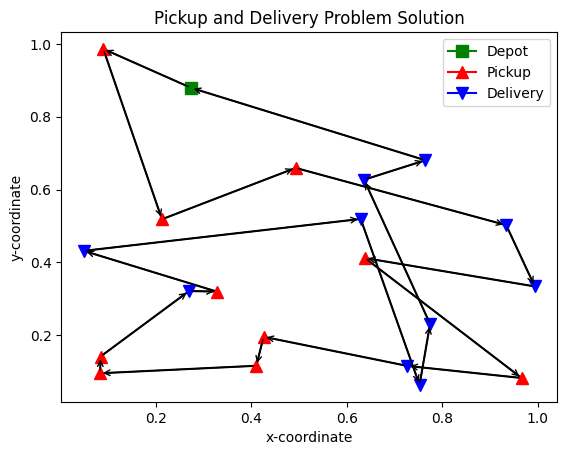

Reward: -5.79398775100708


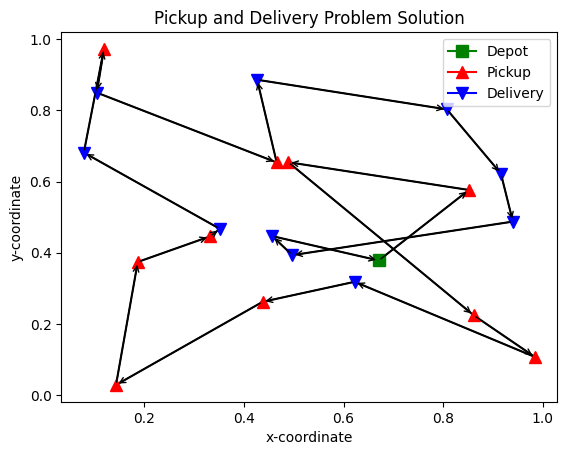

Reward: -5.6444854736328125


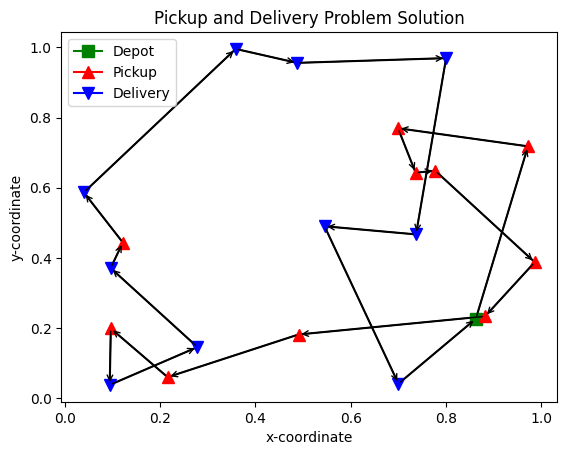

Reward: -6.042241096496582


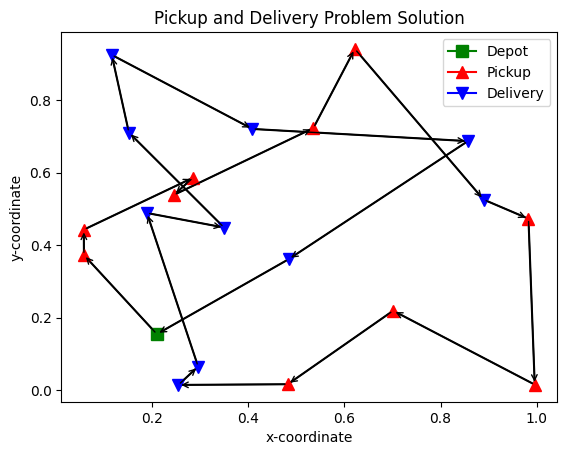

Reward: -6.519842147827148


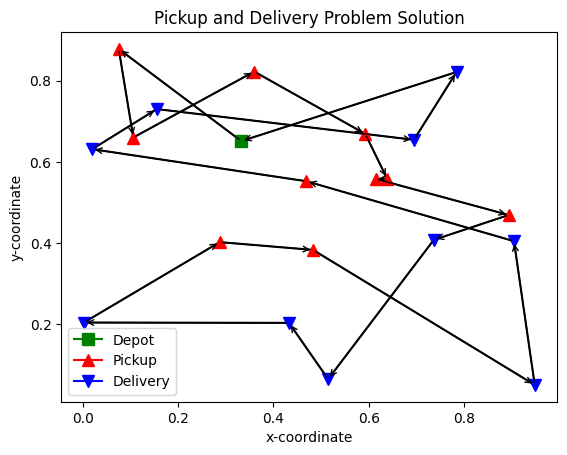

In [47]:
td.set('reward', out['reward'])
td.set('action', out['actions'])
for i in range(5):
    print("Reward:", td['reward'][i].item())
    env.render(td[i])